In [76]:
import os
from glob import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np

image_dir = "./images"
label_dir = "./labels"

images = glob(os.path.join(image_dir, '*.png'))
labels = glob(os.path.join(label_dir, '*.png'))

In [77]:
tags = {0:None, 1:"Buildings", 2:"Fences",3:"Other",4:"Pedestrians",5:"Poles",
         6:"RoadLines",7:"Roads",8:"Sidewalks",9:"Vegetation",10:"Vehicles",11:"Walls",12:"TrafficSigns"}
total_images = len(images)
total_labels = len(labels)
print("Total images:", total_images)
print("Total labels:", total_labels)

Total images: 1000
Total labels: 1000


In [78]:
def crop(img):
    img_copy = np.copy(img)
    #img_copy = cv2.resize(img_copy, (400,300))
    img_copy = img_copy[100:500,:]
    return img_copy

In [79]:
idx = np.random.randint(total_images)
image = cv2.imread(images[idx])
label = cv2.imread(labels[idx])[:,:,2]

image = crop(image)
label = crop(label)

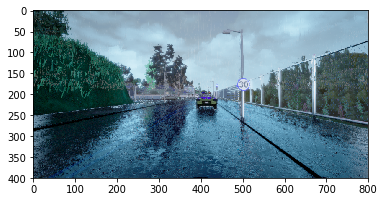

In [80]:
plt.imshow(image)

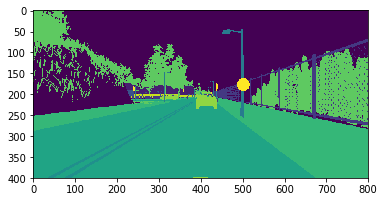

In [82]:
plt.imshow(label)

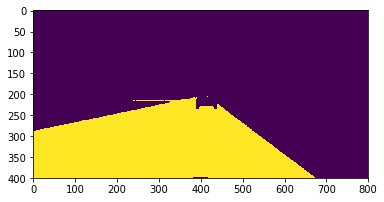

In [95]:
label[label == 6] = 7
lb_road = np.zeros_like(label)
lb_road[label == 7] = 1
plt.imshow(lb_road)

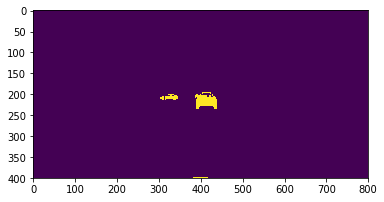

In [96]:
lb_car = np.zeros_like(label)
lb_car[label == 10] = 1
plt.imshow(lb_car)